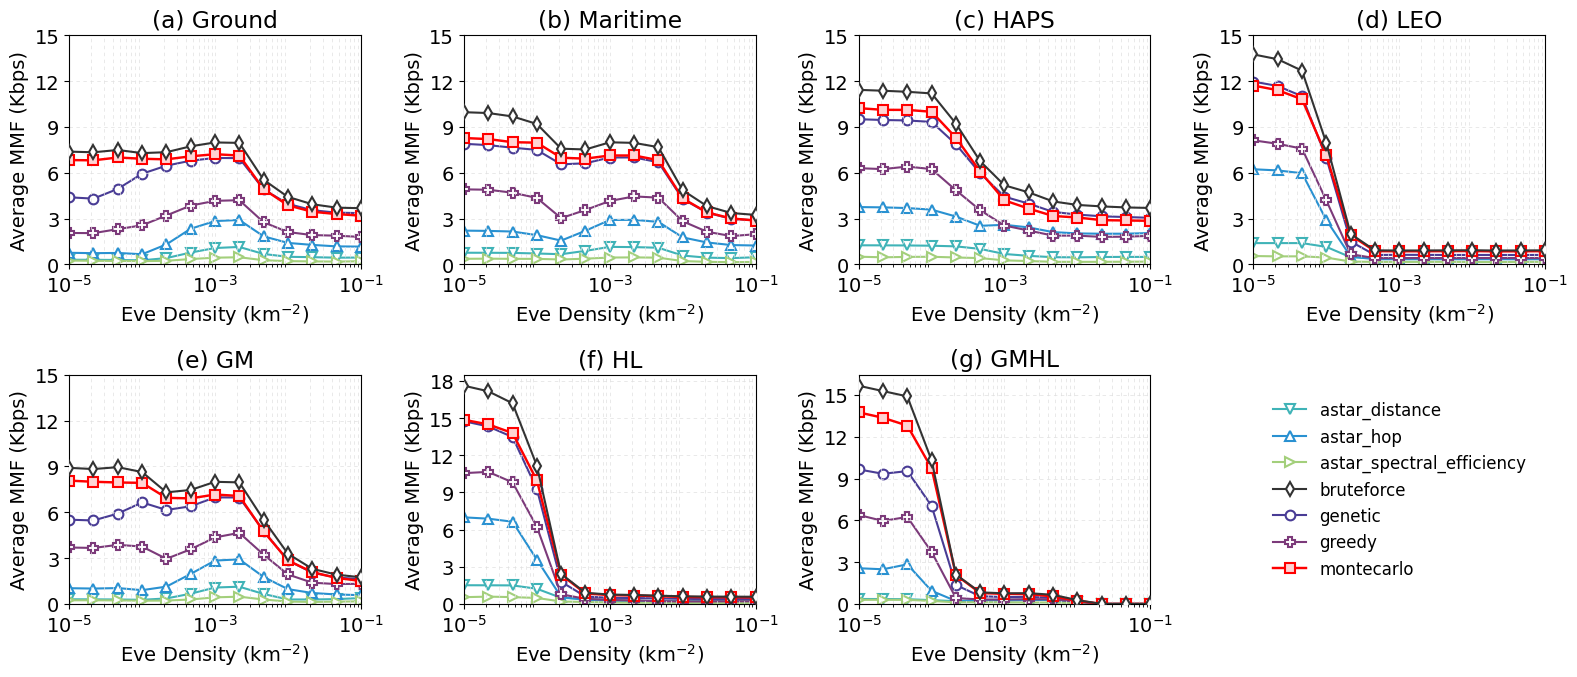

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Create a 2×4 grid of sub‑figures that summarise seven mmf‑vs‑density
experiments (G, M, H, L, GM, HL, GMHL).  
The 8‑th panel (bottom‑right) is reserved for the global legend.

* All comments are written in English as requested.
* Marker styles / colours are taken **verbatim** from the reference script.
* Edit the `base_dirs` dictionary if your output paths differ.
"""

import os
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# ─────────────────────────────────────────────────────────────────────────────
# Global plotting parameters
# ─────────────────────────────────────────────────────────────────────────────
fontsize = 14
plt.rcParams["font.size"] = fontsize
plt.rcParams["axes.labelsize"] = fontsize
plt.rcParams["xtick.labelsize"] = fontsize
plt.rcParams["ytick.labelsize"] = fontsize

marker_list = ["v", "^", ">", "d", "o", "P", "s", "X"]
color_list  = [
    "#3FB3B7", "#2991D1", "#A3CF7B", "#333333",
    "#493C95", "#7C3A7A", "#FF0000", "#E2A72B",
]

# ─────────────────────────────────────────────────────────────────────────────
# Where each experiment group was saved
# (adapt these paths if necessary)
# ─────────────────────────────────────────────────────────────────────────────
root_dir = "/fast/hslyu/mmf_vs_density/"
labels = [
    "(a) Ground",
    "(b) Maritime",
    "(c) HAPS",
    "(d) LEO",
    "(e) GM",
    "(f) HL",
    "(g) GMHL",
]
base_dirs = {
    labels[0] : root_dir + "results_mmf_vs_density_G",
    labels[1] : root_dir + "results_mmf_vs_density_M",
    labels[2] : root_dir + "results_mmf_vs_density_H",
    labels[3] : root_dir + "results_mmf_vs_density_L",
    # labels[4] : root_dir + "results_mmf_vs_density_GM",
    labels[4] : "/fast/hslyu/results_mmf_vs_density_GM",
    labels[5] : root_dir + "results_mmf_vs_density_HL",
    labels[6] : root_dir + "results_mmf_vs_density_GMHL",
}

# Densities swept in the experiment script
densities = np.logspace(-5, -1, 13, base=10)

# ─────────────────────────────────────────────────────────────────────────────
# Helper – collect (mean) throughput for every scheme at each density
# ─────────────────────────────────────────────────────────────────────────────
def load_results(root: str):
    """
    Return:
        dict[density] -> dict[scheme] -> mean‑throughput‑kbps
    """
    results = {}

    for dens in densities:
        dens_dir = os.path.join(root, f"density_{dens:.2e}")
        if not os.path.isdir(dens_dir):
            continue

        # All experiment instances inside this density directory
        exp_dirs = [
            d for d in os.listdir(dens_dir)
            if d.startswith("exp_") and os.path.isdir(os.path.join(dens_dir, d))
        ]

        scheme_values = {}
        for exp in exp_dirs:
            fp = os.path.join(dens_dir, exp, "result.json")
            if not os.path.isfile(fp):
                continue
            with open(fp, "r") as f:
                data = json.load(f)

            if "bruteforce" in data and "montecarlo" in data:
                if data["bruteforce"] < data["montecarlo"]:
                    data["bruteforce"] = data["montecarlo"]

            for scheme, tp in data.items():
                scheme_values.setdefault(scheme, []).append(tp / 1_000.0)  # to Kbps

        if scheme_values:
            results[dens] = {k: np.mean(v) for k, v in scheme_values.items()}

    return results


# ─────────────────────────────────────────────────────────────────────────────
# Main plotting routine (2 rows × 4 cols)
# ─────────────────────────────────────────────────────────────────────────────
fig, axes = plt.subplots(
    nrows=2, ncols=4, figsize=(16, 7), sharex=False, sharey=False
)

# Flatten for easier indexing; the last axis is the legend placeholder
axes_flat = axes.flatten()
legend_ax = axes_flat[-1]
legend_ax.axis("off")  # no plotting in legend panel

# Iterate over the seven experiment groups
for idx, (label, root) in enumerate(base_dirs.items()):
    ax = axes_flat[idx]

    # ---------------------------------------------------------------------
    # Load results and gather all schemes present
    # ---------------------------------------------------------------------
    all_res = load_results(root)
    if not all_res:
        ax.set_title(f"{label}  (NO DATA)")
        ax.axis("off")
        continue

    schemes = sorted({sc for v in all_res.values() for sc in v.keys()})

    # ---------------------------------------------------------------------
    # Plot each scheme
    # ---------------------------------------------------------------------
    for si, scheme in enumerate(schemes):
        y_vals = [all_res.get(d, {}).get(scheme, np.nan) for d in densities]

        # copy styling logic from reference script
        zorder            = 1
        linewidth         = 1.5
        markerfacecolor   = "w"
        markersize        = 7

        if scheme == "montecarlo":
            markerfacecolor = "#FFD4D4"
            linewidth       = 1.75
            markersize      = 7.5
            zorder          = 2
        elif scheme == "greedy":
            markersize      = 7.5
        elif scheme == "bruteforce":
            zorder          = 3

        ax.plot(
            densities, y_vals,
            linewidth      = linewidth,
            marker         = marker_list[si % len(marker_list)],
            markersize     = markersize,
            markerfacecolor= markerfacecolor,
            markeredgewidth= 1.5,
            color          = color_list[si % len(color_list)],
            label          = scheme,
            zorder         = zorder,
        )

    # ---------------------------------------------------------------------
    # Axis settings
    # ---------------------------------------------------------------------
    ax.set_xscale("log")
    ax.set_xlabel("Eve Density (km$^{-2}$)")
    ax.set_ylabel("Average MMF (Kbps)")
    ax.set_title(label, loc="center")
    ax.grid(True, which="both", linestyle=(0, (5, 5)),
            linewidth=0.5, color="#e0e0e0")
    ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
    ax.set_xticks([1e-5, 1e-3, 1e-1])
    ax.set_xlim(1e-5, 1e-1)
    ax.set_ylim(bottom=0)
    if idx != 5:
        ax.set_yticks(np.arange(0, 16, 3))
    else:
        ax.set_yticks(np.arange(0, 19, 3))

    # # If scheme is LEO, set yticks
    # if idx == 3:
    #     ax.set_yticks([-]


# -------------------------------------------------------------------------
# Global legend in the 8th subplot
# -------------------------------------------------------------------------
handles, labels = axes_flat[0].get_legend_handles_labels()
legend_ax.legend(
    handles, labels, loc="center",
    ncol=1, frameon=False, fontsize=fontsize - 2
)

plt.tight_layout()
plt.savefig("mmf_vs_density_2x4.eps", format="eps", dpi=300)
plt.show()